In [114]:
from sklearn.datasets import fetch_openml 

import numpy as np 
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.base import clone, BaseEstimator
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score

import matplotlib 
import matplotlib.pyplot as plt 
%matplotlib inline 

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))



In [87]:
## No longer supports fetch_ml data 
## Use fetch_openml instead, need to sort the results as well 
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings

In [88]:
## Reorder array - separate the training and the testing parts of the dataset 
def reorder_mnist(mnist, end_train_index=60000):
    '''
    Will return a train set with labels in order (i.e. 0,0,0,...1,1,1,......9,9,9)
    Same for test set
    @note: 
    - Make sure to select last column to get only index and not label (although sorting by label)
    '''
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:end_train_index])]))[:,1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[end_train_index:])]))[:,1]
    mnist.data[:end_train_index] = mnist.data[reorder_train]
    mnist.target[:end_train_index] = mnist.target[reorder_train]
    mnist.data[end_train_index:] = mnist.data[reorder_test + end_train_index]
    mnist.target[end_train_index:] = mnist.target[reorder_test + end_train_index]

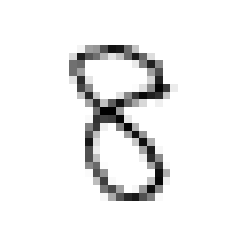

8


In [89]:
## Get the features, response variable 
X, y = mnist['data'], mnist['target']

## Examine one of the instances of the mnist test set 
some_digit = X[3600]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, 
          interpolation='nearest')
plt.axis('off')
plt.show()
print(y[3600])

In [90]:
## Get train and test set, and reorder the training set to 
## ... make sure folds have a good variety of numnbers (using np.random)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
shuffle_indices = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_indices], y_train[shuffle_indices]

## Training a Binary Classifier 

In [91]:
## Build a simple binary classifier (5 or not 5)
## using a Stochastic Gradient Descent Classifier 
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])


array([False])

In [92]:
## Implementing cross validation 
skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5): 
    clone_clf = clone(sgd_clf) # clones and yields estimator with same parameters, but without any data attached to it 
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.9675
0.94685
0.9629


In [104]:
## Use cross_val_score from sklearn.model_selection to evaluate your model 
scores = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring = 'accuracy')
scores

array([0.95045, 0.9583 , 0.9637 ])

In [101]:
## Create a Base Estimator that will predict all False 
## Shows flaws of above model - barely performs any better than the Naive model below 
## Be careful when dealing with classification problems on skewed data! 
class NeverSClassifier(BaseEstimator):
    def fit(self,X,y=None):
        pass
    def predict(Self,X):
        return np.zeros((len(X),1), dtype=bool)
    
never_5_clf = NeverSClassifier() 
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9106 , 0.9113 , 0.90705])

In [107]:
## Confusion Matrix 
## Use cross_val_predict to perform k-fold CV, byt instead of returning eval scores
## ...the function returns the predictions made on each test fold 
## Also use confusion_matrix from sklearn.metrics 
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)
confusion_matrix(y_train_5, y_train_pred)

array([[53154,  1425],
       [ 1235,  4186]])

In [116]:
## Precision and recall 
## Can use sklearn.metrics' functions recall and precision to compute classifier metrics 
print("Precision:",round(precision_score(y_train_5, y_train_pred),2))
print("Recall:",round(recall_score(y_train_5, y_train_pred),2))

## Alternatively, use an F-score
## F-score combines precision and recall into a single metric 
## Pros: Easier to compare multiple models 
## It's the harmonic mean of precision and recall 
## Note: Harmonic mean gives smaller weight to values that are low 
## ... For a high harmonic mean, both prec. and recall need to be high 
print("F1 score", round(f1_score(y_train_5, y_train_pred),2))


## @note on precision and recall 
## @source https://medium.com/@klintcho/explaining-precision-and-recall-c770eb9c69e9 
## Remember: A classifier with high precision is equivalent to casting a very narrow but specialized 
## ...net. You will only catch a small amount of fish and you will miss out on a lot of fish
## ...A classifier with high recall but low precision is equivalent to casting a very wide net: 
## ...You will catch a lot of fish, but also a lot of things you don't want to catch 

Precision: 0.75
Recall: 0.77
F1 score 0.76
